In [1]:
import os
import sys
import networkx as nx
import pandas as pd
import community as community_louvain
import networkx.algorithms.community as nx_comm
nb_dir = os.path.split(os.getcwd())[0]
if nb_dir not in sys.path:
    sys.path.append(nb_dir)
os.chdir('/home/tduricic/Development/workspace/structure-in-gnn')
from src.data import dataset_handle
os.getcwd()

'/home/tduricic/Development/workspace/structure-in-gnn'

In [2]:
def generate_conf_model(G,seed=0):
    din=[x[1] for x in G.in_degree()]
    dout=[x[1] for x in G.out_degree()]
    GNoisy=nx.directed_configuration_model(din,dout,create_using=nx.DiGraph(),seed=seed)
    keys = [x[0] for x in G.in_degree()]
    G_mapping = dict(zip(range(len(G.nodes())),keys))
    G_rev_mapping = dict(zip(keys,range(len(G.nodes()))))
    GNoisy = nx.relabel_nodes(GNoisy,G_mapping)
    return GNoisy

def generate_modified_conf_model(G, seed=0):
    node_labels_dict = nx.get_node_attributes(G,'label')
    unique_node_labels = set(node_labels.values())
    same_label_subgraphs = {}
    for node_label in unique_node_labels:
        same_label_subgraphs[node_label] = nx.DiGraph()
    edges_to_remove = []
    for edge in G.edges:
        if edge[0] in node_labels_dict and edge[1] in node_labels_dict and node_labels_dict[edge[0]] == node_labels_dict[edge[1]]:
            node_label = G.nodes(data=True)[edge[0]]['label']
            same_label_subgraphs[node_label].add_edge(edge[0], edge[1])
            edges_to_remove.append((edge[0], edge[1]))
    G.remove_edges_from(edges_to_remove)
    for label in same_label_subgraphs:
        G.add_edges_from(generate_conf_model(same_label_subgraphs[label], seed).edges)
    return G

In [4]:
# Download datasets
dataset_handle.create_cora()
dataset_handle.create_citeseer()
dataset_handle.create_texas()
dataset_handle.create_washington()
dataset_handle.create_wisconsin()
# dataset_handle.create_cornell()
dataset_handle.create_webkb()
dataset_handle.create_pubmed()

File downloaded and extracted!
Created data/graphs/processed/cora/cora.cites and data/graphs/processed/cora/cora.content
File downloaded and extracted!
Created data/graphs/processed/citeseer/citeseer.cites and data/graphs/processed/citeseer/citeseer.content
File downloaded and extracted!
Created data/graphs/processed/texas/texas.cites and data/graphs/processed/texas/texas.content
File downloaded and extracted!
Created data/graphs/processed/washington/washington.cites and data/graphs/processed/washington/washington.content
File downloaded and extracted!
Created data/graphs/processed/wisconsin/wisconsin.cites and data/graphs/processed/wisconsin/wisconsin.content
File downloaded and extracted!
Created data/graphs/processed/webkb/webkb.cites and data/graphs/processed/webkb/webkb.content
File downloaded and extracted!


In [5]:
# Create G and label CM G from datasets
datasets = ['cora', 'citeseer', 'webkb', 'pubmed'] #'cornell']
graphs = {}
for dataset in datasets:
    graph_filepath = 'data/graphs/processed/'+ dataset +'/'+ dataset +'.cites'
    original_G = nx.Graph()
    with open(graph_filepath, 'r') as f:
        for line in f:
            edge = line.split()
            original_G.add_edge(edge[0], edge[1])
    node_labels = {}
    features_filepath =  'data/graphs/processed/' + dataset + '/' + dataset + '.content'
    with open(features_filepath, 'r') as f:
        for line in f:
            features = line.split()
            node_id = features[0]
            label = features[-1]
            node_labels[node_id] = label
    for node_id in original_G.nodes:
        if node_id in node_labels:
            original_G.nodes[node_id]['label'] = node_labels[node_id]
    label_cm_G = generate_modified_conf_model(original_G)    
    graphs[dataset] = {'original': original_G, 'label_cm':label_cm_G}

In [6]:
# Run community detection and calculate modularity on original and CM graphs
for dataset in graphs:
    original_G_best_partition = community_louvain.best_partition(graphs[dataset]['original'])
    label_cm_G_best_partition = community_louvain.best_partition(graphs[dataset]['label_cm'])
    graphs[dataset]['num_communities_original'] = len(set(original_G_best_partition.values()))
    graphs[dataset]['num_communities_label_cm'] = len(set(label_cm_G_best_partition.values()))
    original_communities = {}
    for node_id in original_G_best_partition:
        community_id = original_G_best_partition[node_id]
        if community_id not in original_communities:
            original_communities[community_id] = []
        original_communities[community_id].append(node_id)
    label_cm_communities = {}
    for node_id in label_cm_G_best_partition:
        community_id = label_cm_G_best_partition[node_id]
        if community_id not in label_cm_communities:
            label_cm_communities[community_id] = []
        label_cm_communities[community_id].append(node_id)
    graphs[dataset]['modularity_original'] = nx_comm.modularity(graphs[dataset]['original'], list(original_communities.values()))
    graphs[dataset]['modularity_label_cm'] = nx_comm.modularity(graphs[dataset]['label_cm'], list(label_cm_communities.values()))

In [22]:
barplot_results = []
for dataset in graphs:
    barplot_results.append({
        'dataset':dataset,
        'Number of communities':graphs[dataset]['num_communities_original'],
        'Modularity':graphs[dataset]['modularity_original'],
        'Graph type':'Original'
    })
    barplot_results.append({
        'dataset':dataset,
        'Number of communities':graphs[dataset]['num_communities_label_cm'],
        'Modularity':graphs[dataset]['modularity_label_cm'],
        'Graph type':'Label CM'
    })
df = pd.DataFrame(barplot_results)

In [23]:
df

,dataset,Number of communities,Modularity,Graph type
0,cora,17,0.708513,Original
1,cora,17,0.700748,Label CM
2,citeseer,29,0.712328,Original
3,citeseer,25,0.698399,Label CM
4,webkb,24,0.726933,Original
5,webkb,25,0.729658,Label CM
6,pubmed,196,0.586078,Original
7,pubmed,177,0.583460,Label CM


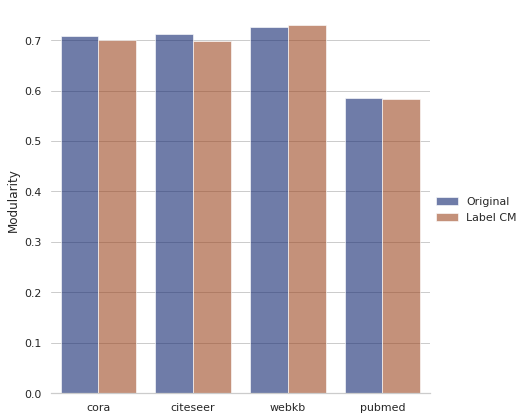

In [18]:
import seaborn as sns
sns.set_theme(style="whitegrid")

# penguins = sns.load_dataset("penguins")

# Draw a nested barplot by species and sex
g = sns.catplot(
    data=df, kind="bar",
    x="dataset", y="Modularity", hue="Graph type",
    ci="sd", palette="dark", alpha=.6, height=6
)
g.despine(left=True)
g.set_axis_labels("", "Modularity")
g.legend.set_title("")

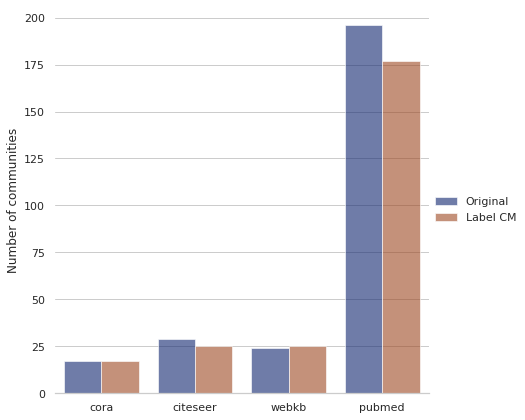

In [21]:
import seaborn as sns
sns.set_theme(style="whitegrid")

# penguins = sns.load_dataset("penguins")

# Draw a nested barplot by species and sex
g = sns.catplot(
    data=df, kind="bar",
    x="dataset", y="Number of communities", hue="Graph type",
    ci="sd", palette="dark", alpha=.6, height=6
)
g.despine(left=True)
g.set_axis_labels("", "Number of communities")
g.legend.set_title("")

In [ ]:
# Calculate d=2 UMAP embeddings for original and CM graphs
# Visualize UMAP embeddings and color by labels